在這一章節中，主要要介紹分類問題。我們主要會使用 MNIST 這個資料集，裡面包含了 70,000 張手寫數字，從 0 ~ 9。

首先，先引入必要的套件並針對 matplotlib 做基礎設定，讓我們之後在繪圖時能有一致的格式。

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]

scikit-learn 在 0.20 後，提供了新的 API `fetch_openml` 來下載公開資料集。

In [4]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, data_home='~/scikit_learn_data')
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    print('start sorting...')
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    print('error!')
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]
X, y = mnist["data"], mnist["target"]
X, y

start sorting...


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 4, 5, 6], dtype=int8))

我們把每個手寫圖片的標準答案透過 pandas 的 series 來看一下分佈狀況如何，可以看到每個數字的圖片數目雖然不同，但相差不遠。

In [5]:
pd.Series(y).value_counts().sort_index(axis=0)

0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
dtype: int64

讓我們取出其中一個數字，透過 matplotlib 畫出來看看。注意，在這裡要先把一維的資料 `reshape` 成 28*28

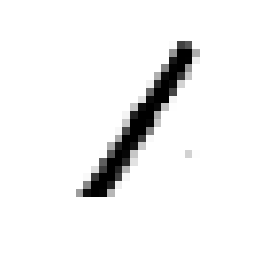

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[10000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

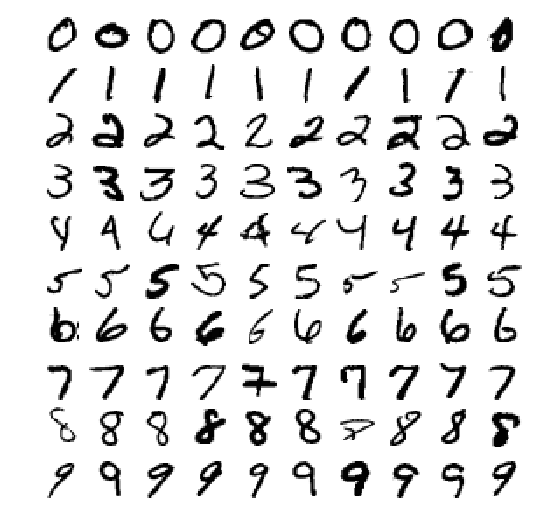

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

切 train/test 資料。前 60,000 筆是 training data，後 10,000 筆是 testing data

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print('Training data size: ', len(X_train))
print('Testing data size: ', len(X_test))

Training data size:  60000
Testing data size:  10000


打亂 training data 的順序

In [10]:
import numpy as np

shuffle_index = np.random.permutation(60000)
print(shuffle_index)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

[12628 37730 39991 ...   860 15795 56422]


## Binary Classification

這裡我們來練習 Binary Classification。讓我們訓練一個分類器，用來辨識 mnist 的圖片是不是 5。先把 training 和 testing 的 y label 都改成 true/false。true 代表是 5，false 代表非 5

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
some_digit = X[0]

# predict some_digit by SGDClassifier trained in the previous step
sgd_result = sgd_clf.predict([some_digit])
sgd_result

array([False])

sklearn 提供了 cross validation 的函式 cross_val_score，這裡我們用 cv=3，也就是 3-fold cross-validation。

In [14]:
from sklearn.model_selection import cross_val_score
sgd_cvs = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
sgd_cvs

array([0.9502 , 0.96565, 0.96495])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


儘管我們上面訓練的分類器看起來 accuracy 好像已經很高了，但是事實上這樣真的就沒問題嗎？我們建立一個分類器，這個分類器永遠不會猜 5。

In [16]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

可以看到這個分類器的 accuracy 也是高達 90% 左右。所以並不是 SGDClassifier 的能力強，而是我們的資料的特性使然，MNIST 本來有 0~9 十類手寫數字，我們只判斷資料是不是 5，那麼標記為 5 的資料量和 “非5” 的比例就是1:9，所以即便是全部猜成是 “非5” 也可以得到90%的準確率。從這個小例子我們可以看出當樣本極其不均衡時，僅僅考慮 accuracy 是無法衡量一個分類器的好壞的。

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

## 使用混淆矩陣 (Confusion Metrics) 來作為模型的衡量維度

[cross_val_predict](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) 會利用 cross-validation 的機制，把每個 fold 的預測結果回傳。

In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [20]:
y_train_perfect_predictions = y_train_5

In [21]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

讓我們來看看以下四種分類器的衡量指標。分別是：
- accuracy
- precision
- recall
- f1-score 

Accuracy 看的是總樣本數中 (TP + TN + FP + FN)，實際預測正確的樣本數 (TP + TN)。
Precision 看的是每次模型預測的所有結果 (TP + FP)，有多少是正確的 (TP)。
Recall 看的是在所有應該被模型預測為正確的集合中 (TP + FN)，有多少是正確被預測出來的 (TP)。
F1-Score 則是 precision 和 recall 的調和平均數 (Harmonic mean)。

- Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2 / (1/Precision) + (1/Recall)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

acc = accuracy_score(y_train_5, y_train_pred)
pre = precision_score(y_train_5, y_train_pred)
rec = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print('acc: %.3f, precision: %.3f, recall: %.3f, f1-score: %.3f' % (acc, pre, rec, f1))

acc: 0.960, precision: 0.769, recall: 0.801, f1-score: 0.785


## 觀察 precison/recall 與 threshold curve

In [24]:
# cross_val_predict return predict results
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions, recalls, thresholds)

[0.09080706 0.09079183 0.09079335 ... 1.         1.         1.        ] [1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00] [-1613405.71147769 -1612415.64410228 -1611701.37464018 ...
   954170.04762499   987947.69103863  1002862.09359785]


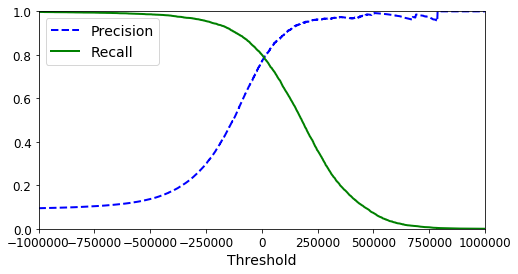

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-1000000, 1000000])
plt.show()

## 觀察 precision-recall curve

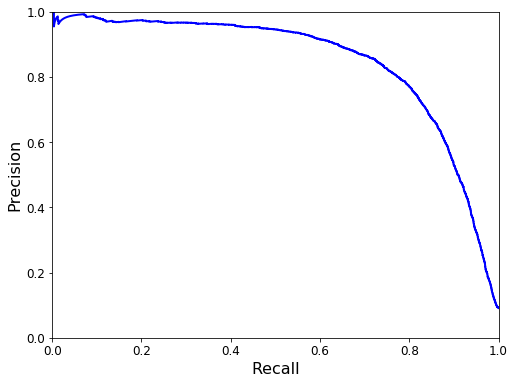

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

## ROC Curve

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99446674, 0.99446674,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 3.87382402e-03, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([ 1002863.09359785,  1002862.09359785,   788024.40783823, ...,
        -1612415.64410228, -1613405.71147769, -2922518.84137436]))

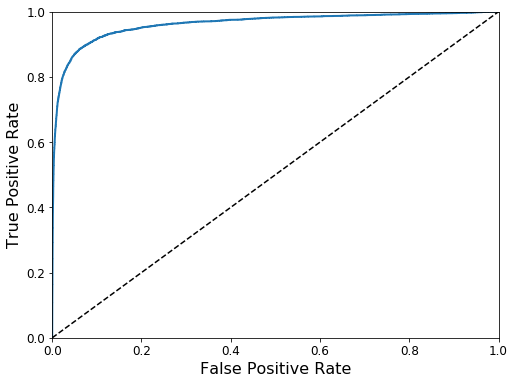

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.show()

## Multiclass classification

In [29]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0], dtype=int8)

In [30]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ 332498.81198868, -657084.47148823, -568796.14973715,
        -337770.41270627, -612186.84724764, -271760.77792114,
        -329777.78221455, -579722.05914369, -342314.37908126,
        -298830.7926227 ]])

In [31]:
np.argmax(some_digit_scores)

0

In [32]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [33]:
sgd_clf.classes_[5]

5

In [34]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0], dtype=int8)

In OneVsOneClassifier, it will create `n*(n-1)/2` classifiers. n = number of classes. In this case, it will create 10*(10-1)2 = 45 classifiers

In [35]:
len(ovo_clf.estimators_)

45